In [2]:
!pip install transformers scikit-learn matplotlib

In [3]:
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Load Qwen Coder Model and Tokenizer
model_name = "Qwen/Qwen2.5-Coder-3B"  # Replace with the exact model name
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
# Extract Embedding Layer
embedding_layer = model.get_input_embeddings()

# Define Tokens to Compare (e.g., Synonyms and Unrelated Words)
words = ["quick", "fast", "slow", "happy", "joyful", "sad", "run", "jog", "walk"]


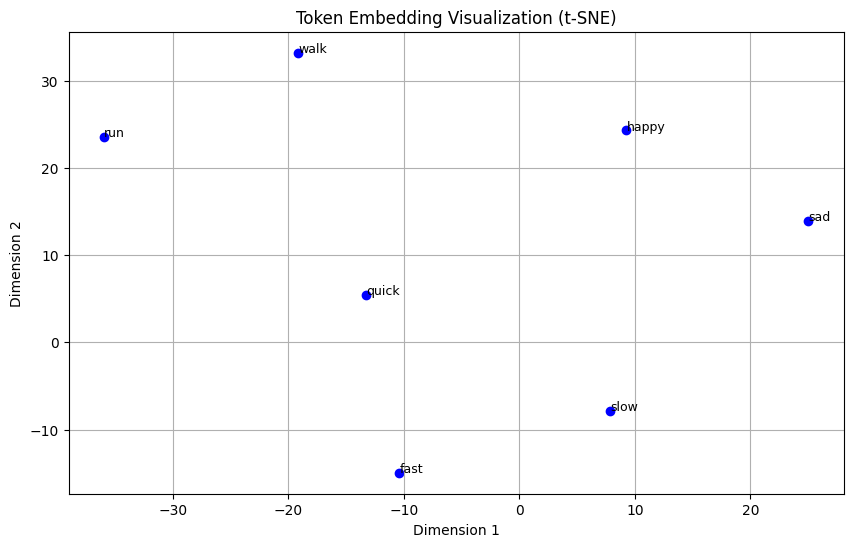

In [7]:
# Tokenize Words and Select the First Token for Each Word
tokens = []
valid_words = []
for word in words:
    token_ids = tokenizer(word, add_special_tokens=False)["input_ids"]
    if len(token_ids) == 1:  # Ensure only single-token words are considered
        tokens.append(token_ids[0])
        valid_words.append(word)

tokens = torch.tensor(tokens)

# Get Embeddings for the Selected Tokens
with torch.no_grad():
    embeddings = embedding_layer(tokens).cpu().numpy()

# Dimensionality Reduction using t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=5)  # Adjusted perplexity
reduced_embeddings = tsne.fit_transform(embeddings)

# Visualization
def plot_embeddings(embeddings, words):
    plt.figure(figsize=(10, 6))
    for i, word in enumerate(words):
        x, y = embeddings[i]
        plt.scatter(x, y, marker='o', color='blue')
        plt.text(x + 0.02, y + 0.02, word, fontsize=9)
    plt.title("Token Embedding Visualization (t-SNE)")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.grid(True)
    plt.show()

plot_embeddings(reduced_embeddings, valid_words)

In [28]:
vocab_size = len(tokenizer)
token_ids = torch.arange(vocab_size)

with torch.no_grad():
    all_embeddings = embedding_layer(token_ids).detach().cpu().numpy()

print(all_embeddings.shape)
n_neighbors = 20  
knn = NearestNeighbors(n_neighbors=n_neighbors, metric="cosine")
knn.fit(all_embeddings)

query_tokens = ["python", "java", "def", "if","torch","transformers","for","pytorch","import"]  # Example query tokens
query_ids = [tokenizer.convert_tokens_to_ids(tokenizer.tokenize(word)[0]) for word in query_tokens]
query_embeddings = embedding_layer(torch.tensor(query_ids)).detach().cpu().numpy()

distances, indices = knn.kneighbors(query_embeddings)

for i, word in enumerate(query_tokens):
    print(f"\nClosest tokens to '{word}':")
    for idx, dist in zip(indices[i], distances[i]):
        token = tokenizer.convert_ids_to_tokens(int(idx))  # Convert NumPy integer to Python integer
        print(f"  Token: {token}, Distance: {dist:.4f}")


(151665, 2048)

Closest tokens to 'python':
  Token: python, Distance: 0.0000
  Token: Ġpython, Distance: 0.1316
  Token: ĠPython, Distance: 0.2439
  Token: Python, Distance: 0.2500
  Token: /python, Distance: 0.3218
  Token: _python, Distance: 0.3310
  Token: -python, Distance: 0.3479
  Token: .python, Distance: 0.3738
  Token: PYTHON, Distance: 0.3921
  Token: ĠPYTHON, Distance: 0.4197
  Token: ython, Distance: 0.5234
  Token: _PY, Distance: 0.5601
  Token: .py, Distance: 0.5937
  Token: py, Distance: 0.6213
  Token: ĠPyObject, Distance: 0.6526
  Token: java, Distance: 0.6589
  Token: php, Distance: 0.6601
  Token: Ġruby, Distance: 0.6630
  Token: Ġpy, Distance: 0.6640
  Token: (PyObject, Distance: 0.6646

Closest tokens to 'java':
  Token: java, Distance: 0.0000
  Token: Ġjava, Distance: 0.1252
  Token: ĉjava, Distance: 0.2738
  Token: (java, Distance: 0.2979
  Token: Java, Distance: 0.3085
  Token: ĠJava, Distance: 0.3181
  Token: -java, Distance: 0.3557
  Token: /java, Distance: 0